In [ ]:
! kaggle

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
! mv kaggle.json /root/.kaggle/kaggle.json
! chmod 600 /root/.kaggle/kaggle.json
! kaggle
! kaggle datasets download paultimothymooney/chest-xray-pneumonia

usage: kaggle [-h] [-v] {competitions,c,datasets,d,kernels,k,config} ...
kaggle: error: too few arguments
 99% 2.28G/2.29G [00:37<00:00, 66.0MB/s]
100% 2.29G/2.29G [00:37<00:00, 65.9MB/s]


In [ ]:
! unzip -qq chest-xray-pneumonia.zip

In [ ]:
rm -rf chest_xray/chest_xray

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import *
from keras.models import Model
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

In [ ]:
trdata = ImageDataGenerator(rescale=1.0/255,horizontal_flip=True,zoom_range=0.2,rotation_range=20,shear_range=0.2)
traindata = trdata.flow_from_directory('/content/chest_xray/train',target_size=(224,224))

vldata = ImageDataGenerator(rescale=1.0/255)
valdata = vldata.flow_from_directory('/content/chest_xray/val', target_size=(224,224))

test_gen=ImageDataGenerator(rescale=1.0/255)
test=test_gen.flow_from_directory('/content/chest_xray/test', target_size=(224,224))


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
## IMporting pretrained VGG16 Model

from keras.applications.vgg16 import VGG16
model=VGG16(weights='imagenet',include_top=True,input_shape=(224,224,3)) 

In [ ]:
x=Dense(1024, activation='relu')(model.layers[-4].output)
x=Dropout(0.7)(x) 
x=Dense(512,activation='relu')(x) 
x=Dropout(0.5)(x)
preds=Dense(2,activation='softmax')(x)
model=Model(model.input,preds)
#model.summary()

In [ ]:
for layer in model.layers[:-10]:
  layer.trainable = False

for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f7a5a6f9630> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5a6f9198> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5a6f9898> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7a5a6f9da0> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5a6f9e80> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5a4d3e80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7a590f9550> False
<keras.layers.convolutional.Conv2D object at 0x7f7a590f99b0> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5abab320> False
<keras.layers.convolutional.Conv2D object at 0x7f7a5ababe80> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7a590fd908> False
<keras.layers.convolutional.Conv2D object at 0x7f7a590fd748> False
<keras.layers.convolutional.Conv2D object at 0x7f7a59105438> False
<keras.layers.convolutional.Conv2D object at 0x7f7a59105e10> False
<keras.layers.pooling.MaxPooling2D object at 0x7f7a5910ba58>

In [ ]:
from keras.optimizers import Adam
opt = Adam(lr=0.0001 , decay=1e-5)
model.compile(optimizer=opt,loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("model.h5", monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='auto')

from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

weight = get_weight(traindata.classes)


In [ ]:
hist=model.fit_generator(generator= traindata,
                         steps_per_epoch=len(traindata) , 
                         epochs= 5, validation_data= valdata, 
                         validation_steps=len(valdata), 
                         callbacks=[checkpoint,early],
                         )

Epoch 1/5
163/163 [==============================] - 99s 609ms/step - loss: 0.2587 - accuracy: 0.8940 - val_loss: 0.7342 - val_accuracy: 0.6875

Epoch 00001: val_loss improved from inf to 0.73418, saving model to model.h5
Epoch 2/5
163/163 [==============================] - 96s 590ms/step - loss: 0.1404 - accuracy: 0.9477 - val_loss: 0.5886 - val_accuracy: 0.6875

Epoch 00002: val_loss improved from 0.73418 to 0.58860, saving model to model.h5
Epoch 3/5
163/163 [==============================] - 96s 589ms/step - loss: 0.1194 - accuracy: 0.9569 - val_loss: 0.6620 - val_accuracy: 0.7500

Epoch 00003: val_loss did not improve from 0.58860
Epoch 4/5
163/163 [==============================] - 96s 591ms/step - loss: 0.0982 - accuracy: 0.9676 - val_loss: 0.3099 - val_accuracy: 0.7500

Epoch 00004: val_loss improved from 0.58860 to 0.30994, saving model to model.h5
Epoch 5/5
163/163 [==============================] - 96s 590ms/step - loss: 0.0843 - accuracy: 0.9686 - val_loss: 0.7741 - val_acc

In [ ]:
import keras
model1=keras.models.load_model("model.h5")
model1.evaluate_generator(test,steps=len(test))

[0.5067226886749268, 0.9070512652397156]

In [ ]:
true_classes=test.classes
class_labels=list(test.class_indices.keys())

In [ ]:
predictions=model1.predict_generator(test, steps=len(test))
predictions_classes=np.argmax(predictions,axis=1)
print(confusion_matrix(true_classes,predictions_classes))
cm=confusion_matrix(true_classes,predictions_classes)

[[ 69 165]
 [121 269]]


In [ ]:
report=classification_report(true_classes,predictions_classes,target_names=class_labels)
print(report)

              precision    recall  f1-score   support

      NORMAL       0.36      0.29      0.33       234
   PNEUMONIA       0.62      0.69      0.65       390

    accuracy                           0.54       624
   macro avg       0.49      0.49      0.49       624
weighted avg       0.52      0.54      0.53       624



In [ ]:
img_path='/content/chest_xray/test/NORMAL/IM-0011-0001-0002.jpeg'
x=image.load_img(img_path,target_size=(224,224))
x=image.img_to_array(x)/255.0
x=x.reshape(1,224,224,3)

In [ ]:
!pip uninstall keras-vis
!pip install https://github.com/raghakot/keras-vis/archive/master.zip

In [ ]:
from vis.visualization import visualize_cam
from vis.utils import utils
penultimate_layer_idx = utils.find_layer_idx(model1, "block5_conv3") 

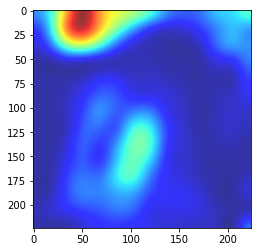

In [ ]:
plt.imshow(visualize_cam(model1,layer_idx=17
                         ,filter_indices=None
                         ,seed_input=x,
                          penultimate_layer_idx = penultimate_layer_idx) ,cmap="jet",alpha=0.8)

(-0.5, 2213.5, 1944.5, -0.5)

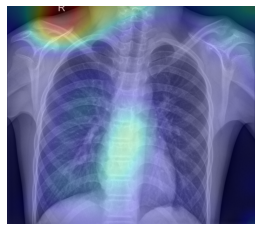

In [ ]:
heatmap = visualize_cam(model1,layer_idx=17
                         ,filter_indices=None
                         ,seed_input=x,
                          penultimate_layer_idx = penultimate_layer_idx)

img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

import matplotlib.cm as cm
# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

plt.imshow(superimposed_img)
plt.axis("off")

In [ ]:
from sklearn.metrics import roc_curve , roc_auc_score
y_pred_keras =model1.predict(test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_classes, ax)

In [ ]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)
print(roc_auc_score(true_classes, ax))

0.4973208415516108


In [ ]:
print(auc_keras)
import seaborn as sns

0.4973208415516108


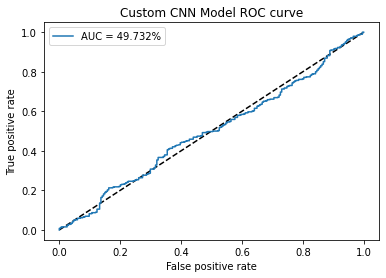

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}%'.format(auc_keras*100)  )
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Custom CNN Model ROC curve')
plt.legend(loc='best')
plt.show()

<Figure size 432x288 with 0 Axes>

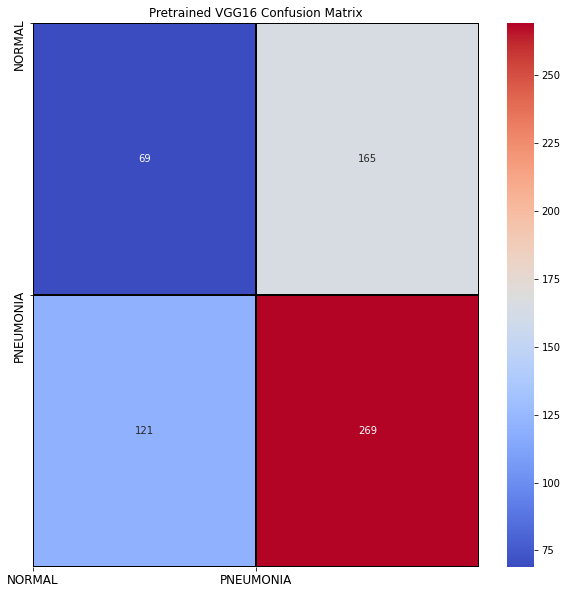

<Figure size 432x288 with 0 Axes>

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "coolwarm", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')
plt.xticks(range(len(labels)), labels, fontsize=12)
plt.yticks(range(len(labels)), labels, fontsize=12)
plt.title("Pretrained VGG16 Confusion Matrix")
plt.figure()